In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import matplotlib as mpl
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

from matplotlib.ticker import StrMethodFormatter
import time
start_total = time.time()

In [2]:
from validity_class import sieplasma

In [3]:
import os
my_path = '/home/tomi/Documentos/Fisica/Tesis/escrito-tesis/images/'

In [4]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [5]:
zl = 0.2; zs = 1.2
Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
c_light = (const.c).to(u.cm/u.second)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')
theta_E_num = theta_E_SIS()
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [6]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)

In [7]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [8]:
from lenstronomy.LensModel.Profiles.plasma_exponential_sie import PlasmaExponentialSIE
perfil = PlasmaExponentialSIE()

In [9]:
def image_position_3(x, y, eta):
    x_s, y_s = x, y
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    print(x_pre)
    print(y_pre)
    mag = [0,0]
    t = [0,0]
    for k in range(len(x_pre)):
        mag[k] = lensModel.magnification(x_pre[k], y_pre[k], kwargs = kwargs_lens_list)
        phi = PlasmaExponentialSIE.function(perfil, x_pre[k], y_pre[k], theta_E_num.value, eta, A, B, C ,psi0_plasma.value, theta_0.value)
        t[k] = ((1+zl)/c_light*Ds*Dl/Dls*( 1/2*( (x_s - x_pre[k] )**2 + (y_s - y_pre[k])**2) - phi**2)*(u.arcsec**2).to('rad**2')).to('s').value
    r = np.abs(mag[0]/mag[1])
    rr = [r,r]
    dt = np.abs(t[0] - t[1])/24/60/60 #convert seconds to days
    dt = [dt,dt]
    return x_pre, y_pre, rr, dt

In [10]:
lens_model_list = ['PlasmaExponentialSIE']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

In [11]:
eta_arr = np.linspace(.05, .2, 50)
r_arr = np.linspace(.15, .3, 50)
x_arr = y_arr = r_arr*np.cos(np.pi/4)

In [12]:
mag = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        kwargs = {'theta_E':theta_E_num.value,'eta':eta_arr[i], 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                        'theta_0':theta_0.value}
        kwargs_lens_list = [kwargs]
        x_image, y_image, r, dt = image_position_3(x_arr[x], x_arr[x], eta_arr[i])
        mag[x][i] = r[0]

[ 0.44014052 -0.44174463]
[ 0.69326445 -0.2779922 ]
[ 0.43278685 -0.44450364]
[ 0.69843172 -0.27263725]
[ 0.42561413 -0.44709836]
[ 0.7033987  -0.26737806]
[ 0.41862357 -0.44953393]
[ 0.70817336 -0.26221809]
[ 0.41181525 -0.45181575]
[ 0.71276389 -0.25715997]
[ 0.40518834 -0.45394939]
[ 0.71717857 -0.25220562]
[ 0.39874115 -0.4559405 ]
[ 0.72142563 -0.24735632]
[ 0.39247134 -0.45779478]
[ 0.72551323 -0.24261276]
[ 0.38637601 -0.45951791]
[ 0.72944931 -0.2379751 ]
[ 0.3804518  -0.46111547]
[ 0.73324162 -0.23344308]
[ 0.37469498 -0.46259299]
[ 0.73689765 -0.22901605]
[ 0.36910159 -0.46395582]
[ 0.7404246  -0.22469302]
[ 0.36366741 -0.4652092 ]
[ 0.74382936 -0.22047274]
[ 0.35838813 -0.46635817]
[ 0.74711851 -0.2163537 ]
[ 0.3532593  -0.46740761]
[ 0.75029831 -0.21233421]
[ 0.34827645 -0.46836221]
[ 0.75337471 -0.20841243]
[ 0.34343511 -0.46922645]
[ 0.75635334 -0.20458638]
[ 0.3387308  -0.47000464]
[ 0.75923954 -0.200854  ]
[ 0.33415912 -0.47070088]
[ 0.76203835 -0.19721314]
[ 0.32971569

[ 0.39966734 -0.4489113 ]
[ 0.73205735 -0.23999829]
[ 0.39381334 -0.45052022]
[ 0.73588795 -0.23563168]
[ 0.38811452 -0.45201572]
[ 0.73958709 -0.23135722]
[ 0.38256782 -0.45340241]
[ 0.74316121 -0.22717461]
[ 0.37716994 -0.45468479]
[ 0.7466165  -0.22308323]
[ 0.37191737 -0.45586726]
[ 0.74995894 -0.21908222]
[ 0.36680649 -0.45695411]
[ 0.75319424 -0.21517052]
[ 0.36183356 -0.45794946]
[ 0.75632788 -0.2113469 ]
[ 0.35699478 -0.45885734]
[ 0.75936507 -0.20760997]
[ 0.35228635 -0.4596816 ]
[ 0.76231077 -0.20395823]
[ 0.34770445 -0.46042595]
[ 0.76516969 -0.20039008]
[ 0.34324527 -0.46109395]
[ 0.76794632 -0.19690385]
[ 0.33890505 -0.46168901]
[ 0.77064489 -0.19349779]
[ 0.33468011 -0.46221439]
[ 0.7732694  -0.19017013]
[ 0.33056678 -0.4626732 ]
[ 0.77582366 -0.18691906]
[ 0.32656152 -0.46306842]
[ 0.77831124 -0.18374275]
[ 0.32266083 -0.46340286]
[ 0.78073554 -0.18063938]
[ 0.31886133 -0.46367925]
[ 0.78309973 -0.17760711]
[ 0.31515972 -0.46390013]
[ 0.78540686 -0.17464413]
[ 0.3115528 

[ 0.35198877 -0.45162037]
[ 0.77397992 -0.19621152]
[ 0.34774822 -0.4521898 ]
[ 0.77665862 -0.19294492]
[ 0.34361508 -0.45269388]
[ 0.77926714 -0.18974901]
[ 0.33958617 -0.45313534]
[ 0.78180891 -0.18662233]
[ 0.33565836 -0.45351681]
[ 0.78428716 -0.18356338]
[ 0.33182858 -0.45384081]
[ 0.78670497 -0.18057068]
[ 0.32809384 -0.45410973]
[ 0.78906524 -0.17764272]
[ 0.32445121 -0.45432588]
[ 0.79137073 -0.17477798]
[ 0.32089784 -0.45449145]
[ 0.79362406 -0.17197495]
[ 0.31743095 -0.45460851]
[ 0.7958277  -0.16923215]
[ 0.31404784 -0.45467908]
[ 0.79798397 -0.16654809]
[ 0.31074591 -0.45470505]
[ 0.8000951  -0.16392131]
[ 0.30752261 -0.45468824]
[ 0.80216318 -0.16135035]
[ 0.30437549 -0.45463037]
[ 0.80419018 -0.1588338 ]
[ 0.30130217 -0.45453308]
[ 0.80617798 -0.15637025]
[ 0.29830034 -0.45439795]
[ 0.80812836 -0.15395834]
[ 0.2953678  -0.45422647]
[ 0.810043   -0.15159673]
[ 0.29250238 -0.45402005]
[ 0.81192348 -0.1492841 ]
[ 0.28970201 -0.45378006]
[ 0.81377132 -0.14701917]
[ 0.28696468

[ 0.32317372 -0.44519978]
[ 0.80404518 -0.16657798]
[ 0.31991236 -0.44522648]
[ 0.80615907 -0.16402816]
[ 0.3167257  -0.44521206]
[ 0.80823123 -0.16152985]
[ 0.31361152 -0.44515809]
[ 0.81026351 -0.15908184]
[ 0.31056767 -0.44506606]
[ 0.81225765 -0.15668293]
[ 0.30759204 -0.44493743]
[ 0.81421532 -0.15433193]
[ 0.30468262 -0.44477357]
[ 0.81613808 -0.15202768]
[ 0.30183744 -0.44457577]
[ 0.81802744 -0.14976905]
[ 0.2990546  -0.44434531]
[ 0.81988482 -0.14755491]
[ 0.29633225 -0.44408338]
[ 0.82171155 -0.14538417]
[ 0.29366862 -0.44379111]
[ 0.82350893 -0.14325576]
[ 0.29106198 -0.4434696 ]
[ 0.82527816 -0.14116863]
[ 0.28851068 -0.44311989]
[ 0.8270204  -0.13912176]
[ 0.28601309 -0.44274298]
[ 0.82873675 -0.13711413]
[ 0.28356766 -0.44233981]
[ 0.83042825 -0.13514479]
[ 0.28117289 -0.44191129]
[ 0.83209589 -0.13321277]
[ 0.27882733 -0.44145829]
[ 0.83374062 -0.13131715]
[ 0.27652957 -0.44098163]
[ 0.83536332 -0.12945702]
[ 0.27427826 -0.44048211]
[ 0.83696487 -0.12763151]
[ 0.47874682

[ 0.30813989 -0.43497956]
[ 0.82606562 -0.14776618]
[ 0.30543477 -0.43472544]
[ 0.82790039 -0.14564474]
[ 0.30278607 -0.43444176]
[ 0.82970636 -0.14356288]
[ 0.3001922  -0.43412953]
[ 0.83148468 -0.1415197 ]
[ 0.29765163 -0.43378973]
[ 0.83323644 -0.13951428]
[ 0.29516285 -0.43342329]
[ 0.83496268 -0.13754574]
[ 0.29272444 -0.4330311 ]
[ 0.83666441 -0.13561322]
[ 0.29033498 -0.432614  ]
[ 0.83834256 -0.13371588]
[ 0.28799312 -0.43217282]
[ 0.83999805 -0.13185287]
[ 0.28569756 -0.43170834]
[ 0.84163172 -0.1300234 ]
[ 0.48937915 -0.39897666]
[ 0.70634305 -0.27474864]
[ 0.48285324 -0.40136833]
[ 0.71129168 -0.27053348]
[ 0.47643819 -0.40365116]
[ 0.7160954  -0.26635882]
[ 0.47013729 -0.40582662]
[ 0.72075719 -0.26222809]
[ 0.46395314 -0.40789644]
[ 0.72528043 -0.25814437]
[ 0.45788764 -0.40986256]
[ 0.72966879 -0.25411033]
[ 0.4519421  -0.41172712]
[ 0.73392614 -0.25012834]
[ 0.44611727 -0.41349237]
[ 0.73805655 -0.2462004 ]
[ 0.44041342 -0.41516074]
[ 0.74206418 -0.24232822]
[ 0.43483037

[ 0.29693191 -0.42293728]
[ 0.84630602 -0.13210432]
[ 0.49966297 -0.3897715 ]
[ 0.70994859 -0.27278364]
[ 0.49330631 -0.39207304]
[ 0.71483598 -0.26879231]
[ 0.48704933 -0.39427531]
[ 0.71958866 -0.26483373]
[ 0.48089542 -0.39637938]
[ 0.72420894 -0.26091115]
[ 0.47484735 -0.39838652]
[ 0.72869952 -0.25702749]
[ 0.46890728 -0.40029822]
[ 0.73306339 -0.25318539]
[ 0.46307682 -0.40211614]
[ 0.73730378 -0.24938716]
[ 0.45735707 -0.4038421 ]
[ 0.74142409 -0.24563486]
[ 0.45174868 -0.40547802]
[ 0.74542789 -0.24193026]
[ 0.44625185 -0.40702595]
[ 0.74931883 -0.23827489]
[ 0.44086645 -0.408488  ]
[ 0.75310062 -0.23467003]
[ 0.435592   -0.40986635]
[ 0.756777   -0.23111672]
[ 0.43042773 -0.41116323]
[ 0.76035171 -0.22761583]
[ 0.42537261 -0.41238089]
[ 0.76382847 -0.224168  ]
[ 0.42042542 -0.41352159]
[ 0.76721095 -0.22077372]
[ 0.41558472 -0.41458762]
[ 0.77050276 -0.21743329]
[ 0.41084892 -0.41558123]
[ 0.77370742 -0.21414688]
[ 0.40621631 -0.41650466]
[ 0.7768284  -0.21091452]
[ 0.40168507

[ 0.46825533 -0.39438161]
[ 0.74494831 -0.24465506]
[ 0.46274195 -0.39598061]
[ 0.7489431  -0.24111272]
[ 0.4573317  -0.39749765]
[ 0.75283051 -0.23761262]
[ 0.45202479 -0.39893445]
[ 0.75661377 -0.23415614]
[ 0.44682107 -0.40029283]
[ 0.76029614 -0.23074444]
[ 0.44172015 -0.40157466]
[ 0.76388093 -0.22737849]
[ 0.43672137 -0.40278184]
[ 0.76737143 -0.2240591 ]
[ 0.43182384 -0.40391631]
[ 0.77077094 -0.2207869 ]
[ 0.4270265  -0.40498002]
[ 0.77408269 -0.21756238]
[ 0.42232811 -0.40597491]
[ 0.7773099  -0.21438589]
[ 0.4177273  -0.40690295]
[ 0.7804557  -0.21125766]
[ 0.41322258 -0.40776608]
[ 0.78352316 -0.20817778]
[ 0.40881236 -0.40856621]
[ 0.78651529 -0.20514627]
[ 0.40449495 -0.40930526]
[ 0.78943498 -0.20216301]
[ 0.40026863 -0.40998508]
[ 0.79228508 -0.19922782]
[ 0.39613161 -0.41060753]
[ 0.79506831 -0.19634045]
[ 0.39208205 -0.41117439]
[ 0.79778731 -0.19350057]
[ 0.38811811 -0.41168743]
[ 0.80044464 -0.19070777]
[ 0.38423791 -0.41214837]
[ 0.80304275 -0.18796162]
[ 0.38043959

[ 0.42008397 -0.39910447]
[ 0.79028904 -0.20528587]
[ 0.41578743 -0.39985134]
[ 0.79323443 -0.20239221]
[ 0.41157777 -0.40054137]
[ 0.79611164 -0.19954197]
[ 0.40745345 -0.40117618]
[ 0.79892319 -0.19673505]
[ 0.40341291 -0.40175739]
[ 0.80167157 -0.19397129]
[ 0.39945451 -0.40228659]
[ 0.80435917 -0.19125046]
[ 0.39557661 -0.40276532]
[ 0.80698828 -0.18857228]
[ 0.39177756 -0.4031951 ]
[ 0.80956116 -0.1859364 ]
[ 0.38805567 -0.40357743]
[ 0.81207994 -0.18334246]
[ 0.38440927 -0.40391376]
[ 0.81454671 -0.18079003]
[ 0.38083669 -0.40420548]
[ 0.81696345 -0.17827865]
[ 0.37733625 -0.40445398]
[ 0.8193321  -0.17580785]
[ 0.37390629 -0.40466059]
[ 0.8216545  -0.17337711]
[ 0.37054519 -0.40482661]
[ 0.82393241 -0.17098591]
[ 0.36725131 -0.40495329]
[ 0.82616754 -0.16863368]
[ 0.36402307 -0.40504186]
[ 0.82836152 -0.16631987]
[ 0.36085887 -0.40509348]
[ 0.83051592 -0.16404389]
[ 0.35775718 -0.40510931]
[ 0.83263223 -0.16180515]
[ 0.35471647 -0.40509045]
[ 0.83471189 -0.15960306]
[ 0.35173526

[ 0.39192661 -0.3949837 ]
[ 0.82109234 -0.17877927]
[ 0.38841918 -0.39525219]
[ 0.82349109 -0.17636195]
[ 0.38498011 -0.39547975]
[ 0.82584382 -0.17398171]
[ 0.3816079  -0.39566757]
[ 0.82815222 -0.17163814]
[ 0.37830107 -0.39581683]
[ 0.83041794 -0.16933083]
[ 0.37505814 -0.39592866]
[ 0.83264253 -0.16705931]
[ 0.37187768 -0.39600415]
[ 0.83482751 -0.16482311]
[ 0.36875824 -0.39604437]
[ 0.83697433 -0.16262176]
[ 0.3656984  -0.39605036]
[ 0.8390844  -0.16045475]
[ 0.36269679 -0.39602313]
[ 0.84115904 -0.1583216 ]
[ 0.35975204 -0.39596365]
[ 0.84319954 -0.15622178]
[ 0.35686279 -0.39587285]
[ 0.84520713 -0.15415478]
[ 0.35402776 -0.39575166]
[ 0.84718301 -0.15212008]
[ 0.35124563 -0.39560095]
[ 0.8491283  -0.15011716]
[ 0.34851517 -0.39542158]
[ 0.85104409 -0.14814549]
[ 0.34583513 -0.39521437]
[ 0.85293144 -0.14620454]
[ 0.3432043  -0.39498012]
[ 0.85479133 -0.1442938 ]
[ 0.34062153 -0.3947196 ]
[ 0.85662474 -0.14241274]
[ 0.33808564 -0.39443355]
[ 0.85843258 -0.14056085]
[ 0.33559554

[ 0.37649202 -0.38706222]
[ 0.84349292 -0.16100456]
[ 0.37347336 -0.38705737]
[ 0.84559585 -0.15890748]
[ 0.37051034 -0.38702069]
[ 0.84766454 -0.15684168]
[ 0.36760171 -0.38695308]
[ 0.84970018 -0.15480672]
[ 0.36474624 -0.38685539]
[ 0.85170394 -0.15280217]
[ 0.36194271 -0.38672847]
[ 0.85367692 -0.15082758]
[ 0.35918995 -0.38657312]
[ 0.85562018 -0.14888252]
[ 0.35648679 -0.38639012]
[ 0.85753476 -0.14696652]
[ 0.3538321  -0.38618024]
[ 0.85942163 -0.14507913]
[ 0.35122474 -0.3859442 ]
[ 0.86128175 -0.14321991]
[ 0.34866364 -0.38568273]
[ 0.86311601 -0.1413884 ]
[ 0.34614773 -0.38539651]
[ 0.86492529 -0.13958414]
[ 0.34367597 -0.3850862 ]
[ 0.86671043 -0.13780669]
[ 0.54105523 -0.35202112]
[ 0.72747272 -0.2607408 ]
[ 0.53533924 -0.35394553]
[ 0.73208698 -0.25757369]
[ 0.52968804 -0.35580201]
[ 0.73660166 -0.25441792]
[ 0.52410488 -0.35759066]
[ 0.74101732 -0.25127581]
[ 0.51859263 -0.35931169]
[ 0.74533477 -0.24814954]
[ 0.51315377 -0.36096549]
[ 0.74955512 -0.24504117]
[ 0.50779046

[ 0.35909204 -0.37696246]
[ 0.86782084 -0.14195763]
[ 0.35655299 -0.37669889]
[ 0.86965502 -0.1401753 ]
[ 0.35405751 -0.37641133]
[ 0.87146481 -0.13841844]
[ 0.55002797 -0.34371923]
[ 0.73188144 -0.25732292]
[ 0.54444024 -0.34556203]
[ 0.73643379 -0.25431679]
[ 0.53891156 -0.34734228]
[ 0.74089294 -0.25131897]
[ 0.53344509 -0.34905998]
[ 0.74525919 -0.2483316 ]
[ 0.52804364 -0.35071523]
[ 0.74953312 -0.24535669]
[ 0.52270967 -0.35230828]
[ 0.75371556 -0.24239615]
[ 0.51744534 -0.35383944]
[ 0.75780755 -0.23945175]
[ 0.51225249 -0.35530918]
[ 0.76181033 -0.23652519]
[ 0.50713266 -0.35671801]
[ 0.76572528 -0.233618  ]
[ 0.50208714 -0.35806657]
[ 0.76955398 -0.23073163]
[ 0.49711692 -0.35935553]
[ 0.77329808 -0.22786741]
[ 0.49222278 -0.36058567]
[ 0.77695936 -0.22502657]
[ 0.48740526 -0.36175781]
[ 0.78053968 -0.22221021]
[ 0.48266469 -0.36287283]
[ 0.78404095 -0.21941933]
[ 0.47800122 -0.36393165]
[ 0.78746515 -0.21665486]
[ 0.47341482 -0.36493522]
[ 0.79081428 -0.2139176 ]
[ 0.46890528

[ 0.5217946 -0.3466798]
[ 0.76602246 -0.23392074]
[ 0.51675968 -0.34804136]
[ 0.76991289 -0.23114428]
[ 0.51179388 -0.3493467 ]
[ 0.77372129 -0.22838525]
[ 0.5068983  -0.35059637]
[ 0.77744906 -0.22564492]
[ 0.5020738  -0.35179099]
[ 0.78109775 -0.22292448]
[ 0.49732105 -0.35293122]
[ 0.78466895 -0.22022501]
[ 0.49264051 -0.35401779]
[ 0.78816436 -0.21754751]
[ 0.48803248 -0.35505147]
[ 0.79158572 -0.21489289]
[ 0.48349707 -0.35603307]
[ 0.7949348  -0.21226198]
[ 0.47903425 -0.35696343]
[ 0.79821344 -0.20965552]
[ 0.47464383 -0.35784343]
[ 0.80142345 -0.20707417]
[ 0.47032551 -0.35867397]
[ 0.80456669 -0.20451852]
[ 0.46607889 -0.35945595]
[ 0.80764501 -0.20198909]
[ 0.46190343 -0.36019032]
[ 0.81066024 -0.19948632]
[ 0.45779853 -0.36087803]
[ 0.81361422 -0.19701061]
[ 0.4537635  -0.36152002]
[ 0.81650875 -0.19456228]
[ 0.44979757 -0.36211725]
[ 0.81934562 -0.19214159]
[ 0.44589993 -0.36267069]
[ 0.82212658 -0.18974876]
[ 0.44206968 -0.36318128]
[ 0.82485337 -0.18738395]
[ 0.43830591 -

[ 0.48033991 -0.34983285]
[ 0.80878313 -0.20289846]
[ 0.47612914 -0.35060148]
[ 0.81186797 -0.20046014]
[ 0.47198609 -0.35132484]
[ 0.81489157 -0.19804547]
[ 0.46791028 -0.35200375]
[ 0.81785558 -0.19565487]
[ 0.46390117 -0.35263904]
[ 0.82076168 -0.19328872]
[ 0.45995813 -0.35323157]
[ 0.82361151 -0.19094734]
[ 0.45608048 -0.35378216]
[ 0.82640671 -0.18863099]
[ 0.45226748 -0.35429168]
[ 0.82914887 -0.18633989]
[ 0.44851832 -0.35476098]
[ 0.83183957 -0.18407423]
[ 0.44483218 -0.3551909 ]
[ 0.83448037 -0.18183413]
[ 0.44120818 -0.35558229]
[ 0.83707278 -0.17961968]
[ 0.43764542 -0.35593599]
[ 0.83961829 -0.17743096]
[ 0.43414296 -0.35625282]
[ 0.84211834 -0.17526798]
[ 0.43069987 -0.35653363]
[ 0.84457434 -0.17313074]
[ 0.42731516 -0.35677921]
[ 0.84698767 -0.1710192 ]
[ 0.42398787 -0.35699036]
[ 0.84935967 -0.1689333 ]
[ 0.420717   -0.35716789]
[ 0.85169164 -0.16687296]
[ 0.41750156 -0.35731257]
[ 0.85398483 -0.16483806]
[ 0.41434056 -0.35742517]
[ 0.85624049 -0.16282846]
[ 0.41123299

[ 0.45855873 -0.34595871]
[ 0.83621154 -0.18285047]
[ 0.45488651 -0.34638825]
[ 0.83886749 -0.18067882]
[ 0.45127413 -0.34678072]
[ 0.84147592 -0.17853043]
[ 0.4477208  -0.34713687]
[ 0.84403823 -0.1764054 ]
[ 0.4442257  -0.34745746]
[ 0.84655577 -0.17430382]
[ 0.44078798 -0.34774321]
[ 0.84902989 -0.17222574]
[ 0.43740678 -0.34799488]
[ 0.85146189 -0.17017118]
[ 0.43408122 -0.34821319]
[ 0.85385303 -0.16814012]
[ 0.4308104  -0.34839886]
[ 0.85620456 -0.16613255]
[ 0.42759341 -0.34855261]
[ 0.85851768 -0.16414841]
[ 0.42442936 -0.34867514]
[ 0.86079356 -0.16218762]
[ 0.42131731 -0.34876714]
[ 0.86303334 -0.1602501 ]
[ 0.41825637 -0.34882928]
[ 0.86523813 -0.15833572]
[ 0.41524561 -0.34886224]
[ 0.86740899 -0.15644437]
[ 0.41228412 -0.34886667]
[ 0.86954698 -0.15457589]
[ 0.40937099 -0.34884322]
[ 0.87165308 -0.15273013]
[ 0.40650532 -0.3487925 ]
[ 0.87372829 -0.15090693]
[ 0.40368623 -0.34871514]
[ 0.87577355 -0.14910609]
[ 0.40091281 -0.34861175]
[ 0.87778976 -0.14732744]
[ 0.39818419

[ 0.43125964 -0.34008839]
[ 0.86764577 -0.1594266 ]
[ 0.42819484 -0.3401599 ]
[ 0.86986971 -0.15755846]
[ 0.42517896 -0.34020294]
[ 0.87205995 -0.15571162]
[ 0.42221115 -0.34021813]
[ 0.87421748 -0.153886  ]
[ 0.41929059 -0.34020606]
[ 0.87634328 -0.15208149]
[ 0.41641642 -0.34016732]
[ 0.87843829 -0.15029796]
[ 0.41358781 -0.34010248]
[ 0.88050342 -0.14853528]
[ 0.41080393 -0.3400121 ]
[ 0.88253956 -0.14679331]
[ 0.40806397 -0.33989673]
[ 0.88454757 -0.14507188]
[ 0.40536711 -0.33975691]
[ 0.88652828 -0.14337084]
[ 0.40271254 -0.33959318]
[ 0.88848249 -0.14169001]
[ 0.40009947 -0.33940604]
[ 0.890411   -0.14002922]
[ 0.39752711 -0.339196  ]
[ 0.89231455 -0.13838827]
[ 0.58710812 -0.30910222]
[ 0.75219418 -0.24055463]
[ 0.58200515 -0.31062036]
[ 0.75649256 -0.23814573]
[ 0.5769428  -0.31209381]
[ 0.7607198  -0.23573676]
[ 0.57192371 -0.31352236]
[ 0.76487561 -0.23332916]
[ 0.56695032 -0.31490586]
[ 0.76895987 -0.23092434]
[ 0.56202486 -0.31624422]
[ 0.77297266 -0.22852364]
[ 0.55714935

[ 0.41245015 -0.33107772]
[ 0.89331807 -0.14105157]
[ 0.40982511 -0.33090357]
[ 0.89526538 -0.13942346]
[ 0.40724008 -0.3307069 ]
[ 0.89718772 -0.13781398]
[ 0.59532507 -0.30137973]
[ 0.75711788 -0.23631952]
[ 0.59031958 -0.30282968]
[ 0.76136151 -0.23402864]
[ 0.58535156 -0.30423809]
[ 0.76553805 -0.23173652]
[ 0.58042354 -0.30560471]
[ 0.76964714 -0.22944447]
[ 0.57553788 -0.30692937]
[ 0.77368856 -0.22715378]
[ 0.57069672 -0.30821197]
[ 0.7776623  -0.22486567]
[ 0.56590202 -0.30945244]
[ 0.78156848 -0.22258136]
[ 0.56115559 -0.31065081]
[ 0.78540739 -0.22030198]
[ 0.55645902 -0.31180712]
[ 0.78917942 -0.21802864]
[ 0.55181374 -0.31292149]
[ 0.79288513 -0.21576238]
[ 0.54722101 -0.31399409]
[ 0.79652517 -0.21350421]
[ 0.54268195 -0.31502511]
[ 0.80010027 -0.21125509]
[ 0.53819748 -0.31601481]
[ 0.80361128 -0.20901593]
[ 0.53376842 -0.31696348]
[ 0.80705912 -0.20678756]
[ 0.52939542 -0.31787143]
[ 0.81044478 -0.20457081]
[ 0.525079   -0.31873904]
[ 0.8137693  -0.20236643]
[ 0.52081957

In [13]:
mag_p = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        sie_plasma = sieplasma(theta_E_g, eta_arr[i], zl, c_light.decompose().value, Dl.decompose().value, Ds.decompose().value, Dls.decompose().value, psi0_plasma_num, theta_0_num, B, C, 0.07, x_arr[x], x_arr[x])
        R = sie_plasma.R
        mag_p[x][i] = R

In [14]:
X, Eta = np.meshgrid(x_arr, eta_arr)
error = np.abs(mag - mag_p)/mag_p*100

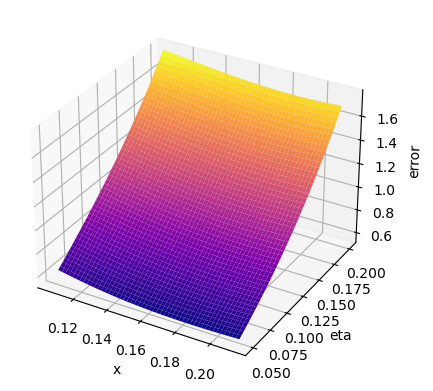

In [15]:
X, Eta = np.meshgrid(x_arr, eta_arr)
error = np.abs(mag - mag_p)/mag_p*100
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Eta, error, cmap='plasma')
ax.set_xlabel('x') #to be constistent with our first convention (sorry for the mess)
ax.set_ylabel('eta')
ax.set_zlabel('error')
plt.show()

In [18]:
mag[25][25]

2.1122319358924235

In [19]:
mag_p[25][25]

2.1342521077797345

In [17]:
end_total = time.time()
print('total time: ',(end_total-start_total)/60.,' minutes')

total time:  1.8482361674308776  minutes
